In [1]:
import cv2, ast
import torchvision
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
from torchvision import transforms
from torch.autograd import Variable
import torch.functional as F
import pickle
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [3]:
df = pd.read_pickle('lung_cancer_train.pkl')

In [4]:
from skimage.transform import resize
def crop_roi(mask, hu_array):
    # Находим область интереса (RoI) путем умножения бинарной маски на массив Hounsfield Units (HU)
    roi = mask * hu_array
    
    # Проверяем, есть ли ненулевые элементы в RoI
    if np.any(roi):
        # Находим границы RoI для обрезки
        nonzero_indices = np.nonzero(roi)
        min_row, max_row = np.min(nonzero_indices[0]), np.max(nonzero_indices[0])
        min_col, max_col = np.min(nonzero_indices[1]), np.max(nonzero_indices[1])

        # Обрезаем RoI до размера 64x64, сохраняя масштаб области рака
        roi_cropped = roi[min_row-10:max_row+10, min_col-10:max_col+10]
        roi_resized = resize(roi_cropped, (64, 64), anti_aliasing=True)
    else:
        # Если RoI пуста, создаем пустое изображение размера 64x64
        roi_resized = np.zeros((64, 64))
    
    return roi_resized


In [5]:
# Применяем функцию crop_roi к каждой строке датафрейма и создаем новый столбец roi
df['roi'] = df.apply(lambda row: crop_roi(row['mask'], row['hu_array_old']), axis=1)

In [6]:
# Define a function to replace 0 with 2000 in a 64x64 NumPy array
def replace_zeros(arr):
    return np.where(arr == 0, 2000, arr)

# Apply the function to each element in the 'roi' column of train_df
df['roi'] = df['roi'].apply(replace_zeros)

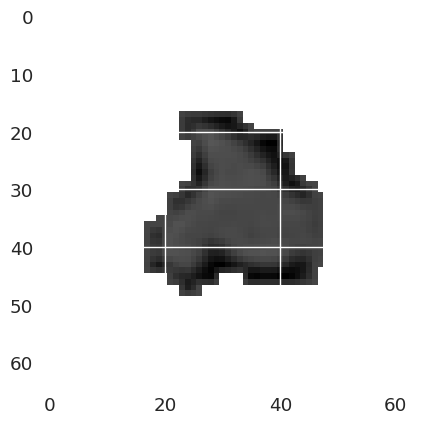

In [7]:
plt.imshow(df['roi'][600], cmap = "gray")

In [3]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [6]:
discriminator = to_device(discriminator, device)

In [7]:
latent_size = 128

In [8]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [9]:
generator = to_device(generator, device)

In [10]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# xb = torch.randn(batch_size, latent_size, 1, 1)
# fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)

In [16]:
class CatsDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()

        self.data = df['roi']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        roi = self.data[index]

        if self.transform:
            augmented = self.transform(image=roi)
            roi = augmented['image']

        return roi


In [17]:
transform = A.Compose([
    A.Normalize(mean=0.5, std=1.0, max_pixel_value=255.0),
    ToTensorV2()
])
df_train = CatsDataset(df, transform)

In [18]:
train_dl = DataLoader(df_train, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [19]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [20]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


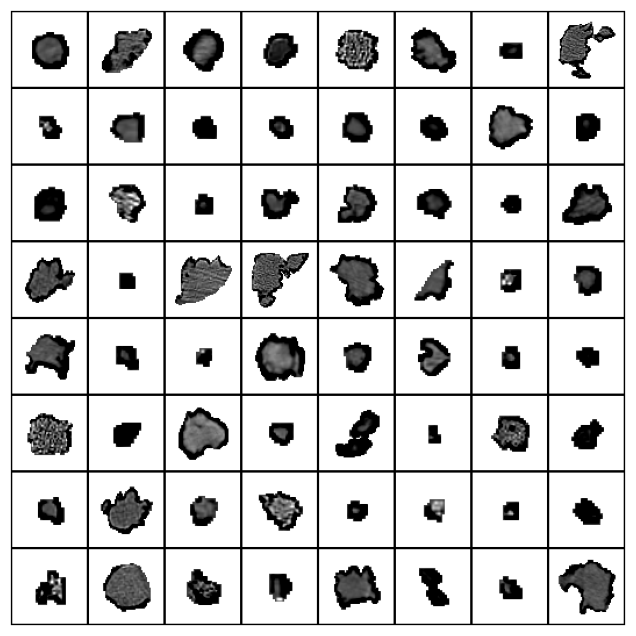

In [21]:
show_batch(train_dl)

In [22]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in (train_dl):
            # Train discriminator
            # Clear discriminator gradients
            real_images = real_images.cuda()
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

    return losses_g, losses_d, real_scores, fake_scores

In [12]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 300

In [14]:
print(sum(p.numel() for p in model['discriminator'].parameters()))

2763648


In [15]:
print(sum(p.numel() for p in model['generator'].parameters()))

3804032


In [24]:
history = fit(model, criterion, epochs, lr)

Epoch [1/300], loss_g: 3.8675, loss_d: 0.6691, real_score: 0.8766, fake_score: 0.3273
Epoch [2/300], loss_g: 6.0514, loss_d: 0.0600, real_score: 0.9843, fake_score: 0.0419
Epoch [3/300], loss_g: 6.4722, loss_d: 0.0271, real_score: 0.9905, fake_score: 0.0172
Epoch [4/300], loss_g: 6.7899, loss_d: 0.0139, real_score: 0.9958, fake_score: 0.0095
Epoch [5/300], loss_g: 6.8987, loss_d: 0.0088, real_score: 0.9968, fake_score: 0.0056
Epoch [6/300], loss_g: 6.9518, loss_d: 0.0062, real_score: 0.9981, fake_score: 0.0042
Epoch [7/300], loss_g: 6.9903, loss_d: 0.0049, real_score: 0.9985, fake_score: 0.0033
Epoch [8/300], loss_g: 7.2127, loss_d: 0.0064, real_score: 0.9984, fake_score: 0.0048
Epoch [9/300], loss_g: 7.4208, loss_d: 0.0066, real_score: 0.9979, fake_score: 0.0045
Epoch [10/300], loss_g: 7.5044, loss_d: 0.0064, real_score: 0.9978, fake_score: 0.0042
Epoch [11/300], loss_g: 7.5242, loss_d: 0.0052, real_score: 0.9984, fake_score: 0.0036
Epoch [12/300], loss_g: 7.5242, loss_d: 0.0039, real

In [25]:
device

device(type='cuda')

In [26]:
def save_samples(latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    return fake_images

In [27]:
torch.save(model, 'GAN.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


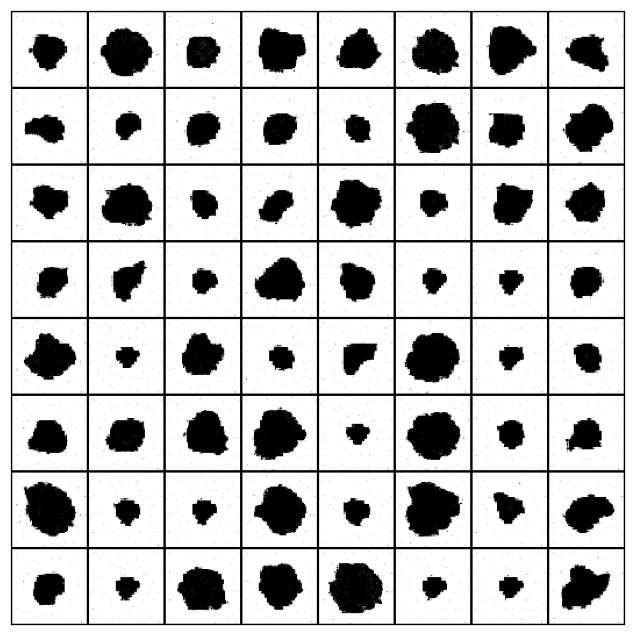

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fake_images = save_samples(fixed_latent, show=True)

In [29]:
fake_images.shape

torch.Size([64, 1, 64, 64])

In [30]:
losses_g, losses_d, real_scores, fake_scores = history

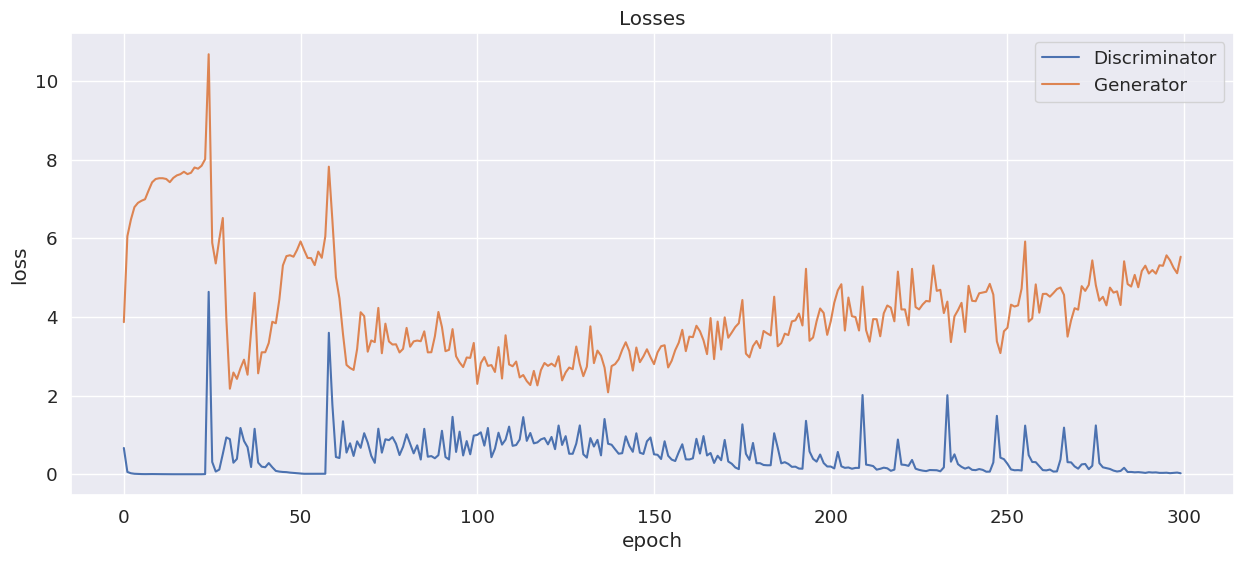

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

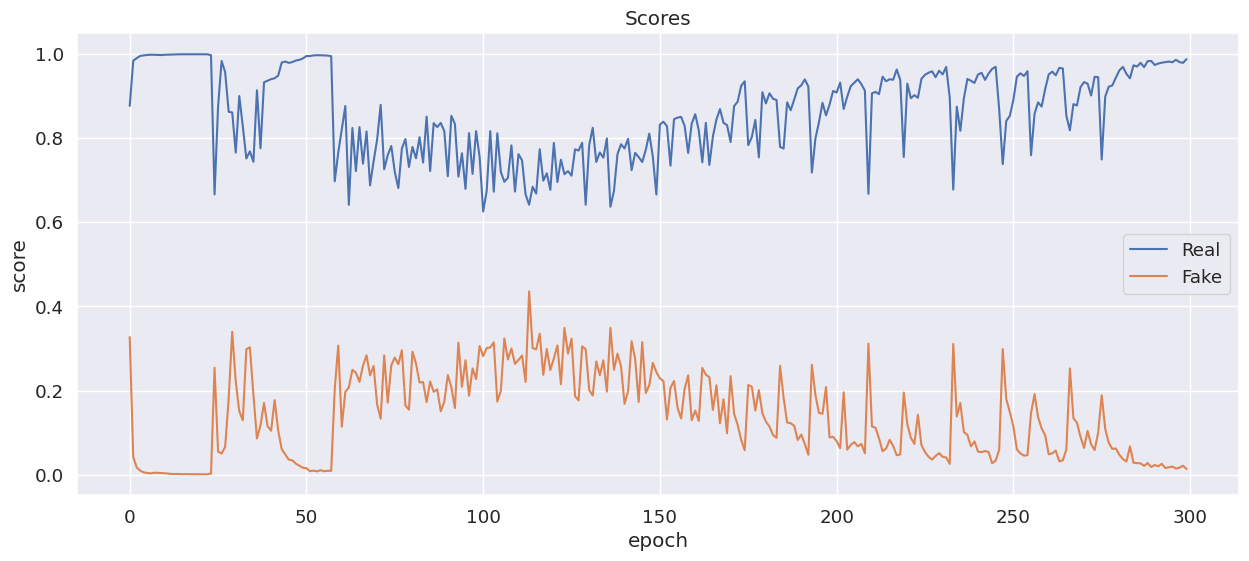

In [32]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [33]:
import numpy as np

# Предположим, что output имеет размер (batch_size, channels, height, width)
# Например, (16, 1, 64, 64) для изображений размером 64x64 с 1 каналом (градации серого)

# Создаем список для хранения преобразованных в numpy array output
generated_dataset = []
for i in range(14):
    fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
    output = fake_images = generator(fixed_latent)
    for img_idx in range(output.shape[0]):
        # Получаем текущее изображение
        current_img = output[img_idx]

        # Преобразуем изображение в numpy array
        current_img_np = current_img.squeeze().cpu().detach().numpy()  # Убираем размерность каналов и преобразуем в numpy array

        # Добавляем изображение в датасет
        generated_dataset.append(current_img_np)

# Теперь у вас есть датасет, где каждая строка содержит один сгенерированный output в формате numpy array
print("Размер датасета:", len(generated_dataset))


Размер датасета: 896


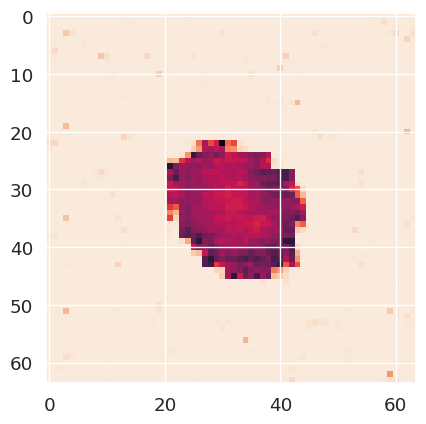

In [34]:
plt.imshow(generated_dataset[100])

In [35]:
generated_dataset[0].shape

(64, 64)

In [36]:
# Создаем датафрейм из списка numpy массивов
df_new = pd.DataFrame({'generated_images': generated_dataset})

# Теперь у вас есть датафрейм, где каждая строка содержит одно сгенерированное изображение в виде numpy массива
print("Размер датафрейма:", df_new.shape)

Размер датафрейма: (896, 1)


In [37]:
df_new.to_pickle("df_generated_cencer_by_gan.pkl")

In [38]:
df_new

,generated_images
0,"[[0.99957716, 0.99994725, 0.999998, 0.9998689,..."
1,"[[0.99886376, 0.9998478, 0.9999916, 0.999729, ..."
2,"[[0.9985019, 0.9997156, 0.9999755, 0.9991824, ..."
3,"[[0.9995942, 0.9999554, 0.9999976, 0.99989456,..."
4,"[[0.9996633, 0.9999727, 0.99999917, 0.9999101,..."
...,...
891,"[[0.9986551, 0.99971104, 0.99997383, 0.9991998..."
892,"[[0.9993736, 0.9999289, 0.9999955, 0.9998073, ..."
893,"[[0.9997186, 0.9999795, 0.9999991, 0.99993104,..."
894,"[[0.9997942, 0.9999834, 0.9999991, 0.9999277, ..."
